In [2]:
#Importing the required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [4]:
# Hyperparameters
batch_size = 128
latent_dim = 100
epochs = 100
learning_rate = 0.0002

In [5]:
# FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.fc(z)
        return out


In [7]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out


In [8]:
# Initialize the generator and discriminator
generator = Generator(latent_dim)
discriminator = Discriminator()

In [9]:
# Loss function
criterion = nn.BCELoss()

In [10]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)


In [11]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)

gen_losses = []
disc_losses = []

for epoch in range(epochs):
    for i, batch in enumerate(train_loader):
        real_images, _ = batch
        real_images = real_images.to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Real images
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        real_output = discriminator(real_images)
        D_real_loss = criterion(real_output, real_labels)
        
        # Fake images
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        fake_output = discriminator(fake_images.detach())
        D_fake_loss = criterion(fake_output, fake_labels)
        
        # Total discriminator loss
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        optimizer_D.step()
        
        # Train Generator
        optimizer_G.zero_grad()
        
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_output = discriminator(fake_images)
        G_loss = criterion(fake_output, real_labels)
        G_loss.backward()
        optimizer_G.step()
        
        # Record losses
        gen_losses.append(G_loss.item())
        disc_losses.append(D_loss.item())
        
        if (i + 1) % 200 == 0:
            print(
                f'Epoch [{epoch + 1}/{epochs}], '
                f'Step [{i + 1}/{len(train_loader)}], '
                f'D_loss: {D_loss.item():.4f}, '
                f'G_loss: {G_loss.item():.4f}'
            )


Epoch [1/100], Step [200/469], D_loss: 0.2798, G_loss: 3.0296
Epoch [1/100], Step [400/469], D_loss: 0.2775, G_loss: 2.3854
Epoch [2/100], Step [200/469], D_loss: 1.2962, G_loss: 1.3225
Epoch [2/100], Step [400/469], D_loss: 0.1869, G_loss: 3.6558
Epoch [3/100], Step [200/469], D_loss: 1.0076, G_loss: 3.0061
Epoch [3/100], Step [400/469], D_loss: 0.1919, G_loss: 3.6249
Epoch [4/100], Step [200/469], D_loss: 0.5697, G_loss: 3.5342
Epoch [4/100], Step [400/469], D_loss: 0.4872, G_loss: 3.9249
Epoch [5/100], Step [200/469], D_loss: 0.9019, G_loss: 3.9237
Epoch [5/100], Step [400/469], D_loss: 0.6029, G_loss: 2.5866
Epoch [6/100], Step [200/469], D_loss: 0.9696, G_loss: 3.0360
Epoch [6/100], Step [400/469], D_loss: 1.0001, G_loss: 1.6446
Epoch [7/100], Step [200/469], D_loss: 0.4556, G_loss: 3.0823
Epoch [7/100], Step [400/469], D_loss: 0.8196, G_loss: 2.4371
Epoch [8/100], Step [200/469], D_loss: 0.4900, G_loss: 4.1383
Epoch [8/100], Step [400/469], D_loss: 0.2895, G_loss: 4.3212
Epoch [9

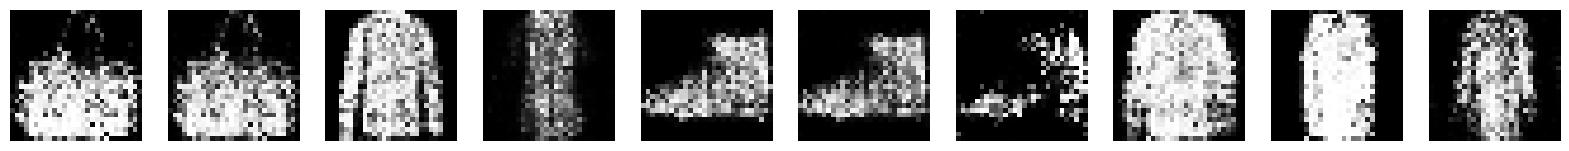

In [12]:
# Generate and plot some fake images
num_samples = 10
fake_images = generator(torch.randn(num_samples, latent_dim).to(device))
fake_images = 0.5 * fake_images + 0.5  # Rescale the images to [0, 1]

fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
for i in range(num_samples):
    axes[i].imshow(fake_images[i].cpu().detach().view(28, 28), cmap='gray')
    axes[i].axis('off')
plt.show()


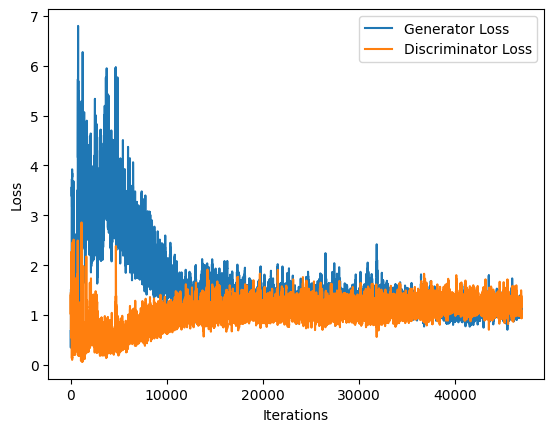

In [13]:
# Plot the generator and discriminator losses
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()
